## The dogs and cats dataset

The dogs and cats dataset was first introduced for a Kaggle competition in 2013. It is available [here](https://www.kaggle.com/c/dogs-vs-cats/data). You can use the kaggle utility to get the dataset, or simply download the [train.zip](https://www.kaggle.com/c/dogs-vs-cats/download/train.zip) file (about 540 MB).

The instructions in this section are for Linux or macOS. If you work on Windows, I'm sure you can easily find a way to do that (e.g. use 7-zip do unpack the archive, and Windows Explorer to create directories and move files around).

Once downloaded, unzip the archive: 

```
unzip train.zip
```

Go to the train directory, and list its contents: 

```
cd train
ls 
```

You will see a lot of images of dogs and cats. 

In the next sections, we will see that Keras makes it easy to retrieve images from disk with the  [flow_from_directory](https://keras.io/preprocessing/image/#flow_from_directory) method of the [ImageDataGenerator](https://keras.io/preprocessing/image/#imagedatagenerator-class) class. 

This method however requires the images from the different classes to be sorted in different directories. So we will put all dog images in `train/dogs`, and all cat images in `train/cats`:

```
mkdir cats 
mkdir dogs
find . -name 'dog.*' -exec mv {} dogs/ \;
find . -name 'cat.*' -exec mv {} cats/ \; 
```

You might be wondering why I used `find` instead of a simple `mv` to move the files. It's because with `mv`, the shell needs to pass a very large number of arguments to the command (all the file names), and there is a limitation on this number. With `find`, we can work around this limitation.

Now the dataset is ready on your local computer, but you will need to access it from Google Colab to train your neural network...

How to do that? That's the subject of the next section!


## Access your dataset from Google Colab with Google Drive

To access a large dataset on Google Colab, the easiest is probably to use Google Drive. 

First, copy your dataset to your Google Drive. In the following I will assume that you put it in a directory called `datasets/dogs_vs_cats`: 

```
mv cats <root_of_your_drive>/datasets/dogs_vs_cats
mv dogs <root_of_your_drive>/datasets/dogs_vs_cats
```

You will need to wait until all files are uploaded to Google Drive.

In the meanwhile, let's see how to access the files from Google Colab. 

For this, mount your google drive in the Google Colab machine by executing this cell and following the instructions: 

In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Now that your drive is mounted on the Google Colab machine, go to the `datasets/dogs_vs_cats` directory and list its contents (if this directory is not yet there, please wait until Google Drive is done uploading it):

In [22]:
import os 
import glob
datasetdir = '/content/drive/My Drive/datasets/dogs_vs_cats'
os.chdir(datasetdir)
# now we print the number of files in 
# the cats and dogs directories
if os.path.isdir('cats'):
  print('number of uploaded cat pictures:', len(glob.glob('cats/cat.*')))
if os.path.isdir('dogs'):
  print('number of uploaded dog pictures:', len(glob.glob('dogs/dog.*')))


number of uploaded cat pictures: 12489
number of uploaded dog pictures: 12488


Please wait until all 12 500 dog and 12 500 cat pictures are uploaded before proceeding to next section. 

## A first look at the dogs and cats dataset

We can start investigating the dataset by plotting the first picture in each category:

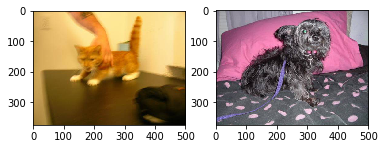

In [0]:
import matplotlib.pyplot as plt
import matplotlib.image as img

plt.subplot(1,2,1)
plt.imshow(img.imread('cats/cat.0.jpg'))
plt.subplot(1,2,2)
plt.imshow(img.imread('dogs/dog.0.jpg'))


Cute. But let's be more specific and see what's the size of our images: 

In [0]:
images = []
for i in range(10):
  im = img.imread('cats/cat.{}.jpg'.format(i))
  images.append(im)
  print('image shape', im.shape, 'maximum color level', im.max())


image shape (374, 500, 3) maximum color level 255
image shape (280, 300, 3) maximum color level 255
image shape (396, 312, 3) maximum color level 255
image shape (414, 500, 3) maximum color level 255
image shape (375, 499, 3) maximum color level 255
image shape (144, 175, 3) maximum color level 255
image shape (303, 400, 3) maximum color level 255
image shape (499, 495, 3) maximum color level 255
image shape (345, 461, 3) maximum color level 255
image shape (425, 320, 3) maximum color level 247


In the image shape, the first two columns correspond to the height and width of the image in pixels, respectively, and the third one to the three color channels. So each pixel contains three values (for red, green, and blue, respectively). 

Please note that the images do not have the same size, nor the same aspect ratio. We'll need to care about that.

It's interesting to see the range of the color levels. For that, we can histogram the color levels for the first image: 


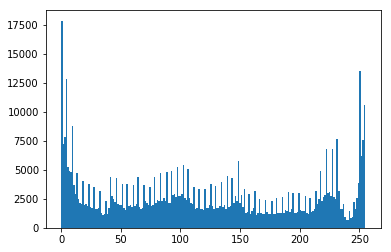

In [0]:
img0 = images[0]
_ = plt.hist(images[0].flatten(), bins=200)

The spiky structure is only a plotting artefact that often occurs with histograms. It's due to the fact that the histogram binning and range choosen by numpy are not adapted to the data being plotted. Let's choose a more adequate binning: 

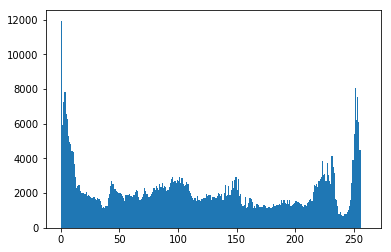

In [0]:
_ = plt.hist(images[0].flatten(), bins=260, range=(0,260))

We have found out that the RGB levels are in the range 0 to 255 (change the range and number of bins in the cell above to zoom around 250 if you want to be sure). 

## Bad dogs and bad cats: dataset cleaning 

If there is only one thing that you should take away from this tutorial it is this:

**You Should Never Trust Your Data**

The data is always dirty.

To get a close look at this dataset, I used a fast image browser to check all images in the dogs and cats directories. Actually, I simply used the Preview application on my mac to browse through the small preview icons. The brain is very fast to spot obvious issues even if you just let your eyes wander on a large number of pictures. So this (tedious) work took me no more than 20 minutes.

And here is what I found.

First, here are the indices for the bad images I could find in both categories:


In [0]:
bad_dog_ids = [5604, 6413, 8736, 8898, 9188, 9517, 10161, 
               10190, 10237, 10401, 10797, 11186]

bad_cat_ids = [2939, 3216, 4688, 4833, 5418, 6215, 7377, 
               8456, 8470, 11565, 12272]

We can then retrieve the images with these ids from the `cats` and `dogs` directories:

In [0]:
def load_images(ids, categ):
  '''return the images corresponding to a list of ids'''
  images = []
  dirname = categ+'s' # dog -> dogs
  for theid in ids: 
    fname = '{dirname}/{categ}.{theid}.jpg'.format(
        dirname=dirname,
        categ=categ, 
        theid=theid
    )
    im = img.imread(fname)
    images.append(im)
  return images

In [0]:
bad_dogs = load_images(bad_dog_ids, 'dog')
bad_cats = load_images(bad_cat_ids, 'cat')

In [0]:
def plot_images(images, ids):
    ncols, nrows = 4, 3
    fig = plt.figure( figsize=(ncols*3, nrows*3), dpi=90)
    for i, (img, theid) in enumerate(zip(images,ids)):
      plt.subplot(nrows, ncols, i+1)
      plt.imshow(img)
      plt.title(str(theid))
      plt.axis('off')


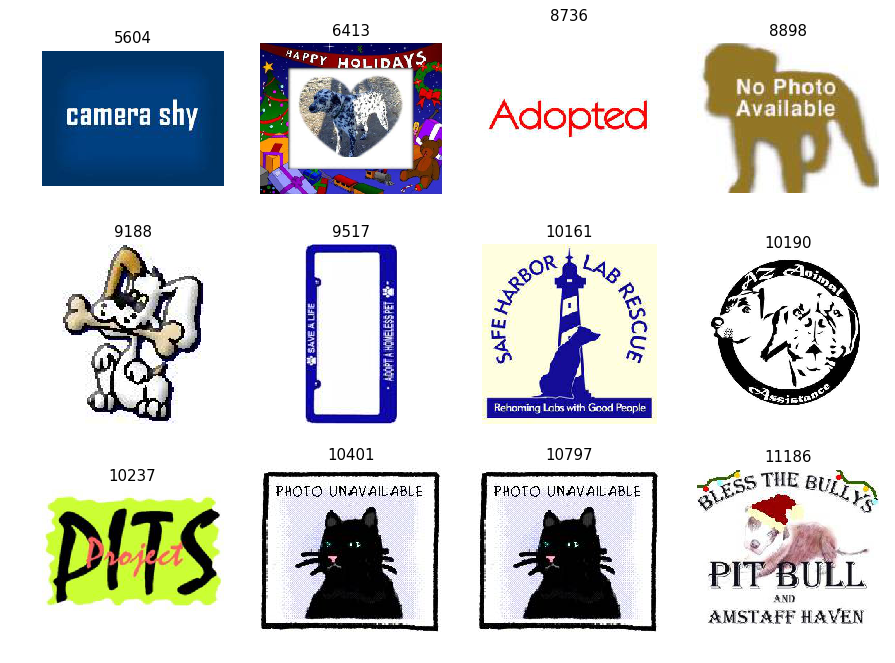

In [0]:
plot_images(bad_dogs, bad_dog_ids)

Some of these images are completely meaningless, like 5604 and 8736.
For 10401 and 10797, we actually see a cat in the picture! sigh... Keeping or not cartoon dogs is debatable. My feeling is that it's going to be better to remove them. Same for 6413, we could keep it, but I'm afraid that the network would focus on the drawings around the dog picture.

Now let's look at the bad cats:



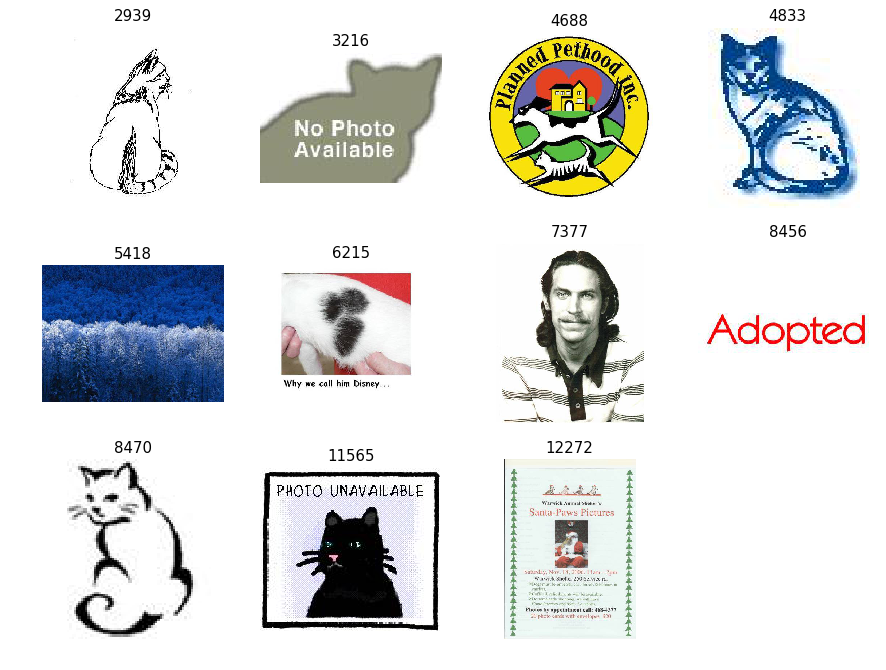

In [0]:
plot_images(bad_cats, bad_cat_ids)

Again, I'm not a fan of keeping cartoon cats for training, but who knows, it could be ok. In image 4688, we have a small cartoon cat and a big cartoon dog... this one should clearly be rejected. In image 6215, we just see fur, so it could be either a cat or a dog, though this fur does seem to belong to a cat. And why is the guy in image 7377 labelled as a cat? no idea...  

It should however be noted that even if we decide to reject these images for training, the trained network might be able to identify them correctly. We'll come back to these images after training to see what the neural net has to say about them. 

Now let's implement a small function to clean up the dataset: 

In [0]:
import glob
import re
import shutil

# matches any string with the substring ".<digits>."
# such as dog.666.jpg
pattern = re.compile(r'.*\.(\d+)\..*')

trash = 'Trash'

def cleanup(ids, dirname): 
  '''move away images with these ids in dirname
  '''
  os.chdir(datasetdir)
  # keep track of current directory
  oldpwd = os.getcwd()
  # go to either cats/ or dogs/
  os.chdir(dirname)
  # create the trash directory. 
  # if it exists, it is first removed
  if os.path.isdir(trash):
    shutil.rmtree(trash)
  os.mkdir(trash)
  fnames = os.listdir()
  print(len(fnames))
  # loop on all files
  for fname in fnames:
    m = pattern.match(fname)
    if m: 
      # extract the id
      the_id = int(m.group(1))
      if the_id in ids:
        # this id is in the list of ids to be trashed
        print('moving to trash:', fname)
        shutil.move(fname, trash)
  os.chdir(oldpwd)
  
def restore(dirname):
  '''restores files in the trash
  I will need this to restore this tutorial to initial state for you
  and you might need it if you want to try training the network
  without the cleaning of bad images
  '''
  os.chdir(datasetdir)
  oldpwd = os.getcwd()
  os.chdir(dirname)
  for fname in os.listdir(trash):
    fname = os.path.join(trash,fname)
    print('restoring', fname)
    shutil.move(fname, os.getcwd())
  os.chdir(oldpwd)
 

In [0]:
cleanup(bad_cat_ids,'cats')

12501
moving to trash: cat.8470.jpg
moving to trash: cat.8456.jpg
moving to trash: cat.7377.jpg
moving to trash: cat.6215.jpg
moving to trash: cat.4688.jpg
moving to trash: cat.4833.jpg
moving to trash: cat.5418.jpg
moving to trash: cat.2939.jpg
moving to trash: cat.3216.jpg
moving to trash: cat.12272.jpg
moving to trash: cat.11565.jpg


In [0]:
cleanup(bad_dog_ids, 'dogs')

12501
moving to trash: dog.9188.jpg
moving to trash: dog.9517.jpg
moving to trash: dog.8736.jpg
moving to trash: dog.8898.jpg
moving to trash: dog.6413.jpg
moving to trash: dog.5604.jpg
moving to trash: dog.10797.jpg
moving to trash: dog.11186.jpg
moving to trash: dog.10161.jpg
moving to trash: dog.10190.jpg
moving to trash: dog.10237.jpg
moving to trash: dog.10401.jpg



## The training and validation datasets 

We will train our neural network on a subset of the dog and cat images called the *training dataset*. 

If it is complex enough (if it has enough parameters), a neural network can start [overfitting](https://thedatafrog.com/overfitting-illustrated/), which means that it starts to learn the specific features of the images in the training dataset. In other words, the network looses its generality, and its ability to classify an arbitrary image as a dog or cat image. 

To make sure that overfitting does not happen, we will evaluate the performance of the network on a *validation dataset*, disjoint from the training dataset. 

In this section, we will construct the training and the testing datasets from our full dataset of dogs and cats. 

We need to use a roughly equal number of dogs and cats in the training. Indeed, having many more images from a given category, a problem called *class imbalance*, would result in a decrease of classification performance. To convince yourself, imagine what would happen if all pictures were cat pictures. In this case, the network would basically be trained into thinking that all pictures are cat pictures. 

So we have removed 11 bad cats and 12 bad dogs already, and we are left with 12 489 cats, and 12 488 dogs. Out of these, we will randomly choose 2000 cats and 2000 dogs for the validation dataset, and we will move these pets to a separate directory. 



## Load the dogs and cats image dataset with Keras 

Neural networks are trained by presenting them with batches of images, each of them with a label identifying the true nature of the image (either cat or dog in our case). A batch may contain of the order of a few tenths to a few hundred images. For each image, the prediction of the network is compared with the corresponding label, and the distance between the predictions of the network and the truth is evaluated for the whole batch. Then, after the processing of the batch, the network parameters are changed in a way to minimize this distance, therefore improving the prediction capability of the network. The training then proceeds iteratively, batch after batch. 

So we need a way to turn our images, now files on disk, into batches of data arrays in memory that can be fed to the network during training.

The [ImageDataGenerator](https://keras.io/preprocessing/image/#imagedatagenerator-class) can readily be used for this purpose. Let's import this class and create an instance of the generator: 



In [0]:
from tensorflow import keras
# this is just a shortcut to the class
ImageDataGenerator = keras.preprocessing.image.ImageDataGenerator
# and this is the instance (the generator object itself)
gen = ImageDataGenerator()

Now, we will use the  [flow_from_directory](https://keras.io/preprocessing/image/#flow_from_directory) method of the `gen` object to start generating batches. 

This method will return an iterator that returns a batch everytime it's iterated on. To see how the data is organized, we can simply create this iterator, and get a first batch to look at it: 

In [0]:
iterator = gen.flow_from_directory(
    os.getcwd(), 
    target_size=(256,256), 
    classes=('dogs','cats')
)

Found 25000 images belonging to 2 classes.


In [0]:
# we can guess that the iterator has a next function, 
# because all python iterators have one. 
batch = iterator.next()
len(batch)

2

The batch has two elements. What's their type? 

In [0]:
print(type(batch[0]))
print(type(batch[1]))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


Two numpy arrays! well, it means we can print their shape and type: 

In [0]:
print(batch[0].shape)
print(batch[0].dtype)
print(batch[0].max())
print(batch[1].shape)
print(batch[1].dtype)


(32, 256, 256, 3)
float32
255.0
(32, 2)
float32


Obviously, the first elements is an array of 32 images with 256x256 pixels, and three color channels, encoded as floats in the range 0. to 255. So the ImageDataGenerator did force the image to 256x256 pixels as requested, but didn't normalize the images between 0. and 1. We will certainly have to do that later. 

The second element contains the 32 corresponding labels. 

Before having a detailed look at the labels, we can plot the first image: 

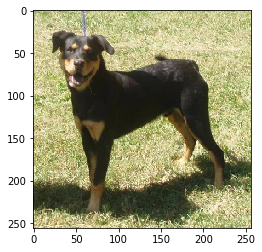

In [0]:
import numpy as np
# we need to cast the image array to integers 
# before plotting as imshow either takes arrays of integers, 
# or of floats normalized to 1. 
plt.imshow(batch[0][0].astype(np.int))

And here is the corresponding label: 

In [0]:
batch[1][0]

array([1., 0.], dtype=float32)

We see that the [ImageDataGenerator](https://keras.io/preprocessing/image/#imagedatagenerator-class) automatically produced a label for each image depending on the directory in which it was found. One-hot encoding is used for the labels, and this is precisely what we need for the classification task we are up to. If you want to know more about one-hot encoding, check my post about a [First Neural Network with Keras](https://thedatafrog.com/first-neural-network-keras/#Preparing-the-dataset). 

We can also guess that the label `[0., 1.]` corresponds to a true cat, and `[1.,0.]` to a true dog. The prediction of the network for a given image will lie somewhere in between, like `[0.6,0.4]` for a Yorkshire (we'll check this with actual Yorkshires!). Still, that's only a guess, and a guess is not enough! we need to be sure, or we take the risk to feed our network with mislabelled images (and garbage in, garbage out). 

Since it might be the first time you use the ImageDataGenerator, you probably want to get more confident about this tool. For that, we are going to develop a small function in the next section to validate the input dataset.  

## Animal plotting for label validation

To validate the dataset labels, we want to check that, for a few batches, the labels are correctly set. So we need a function that can plot a fairly large number of images and label them. Here it is: 

In [0]:
def plot_images(batch):
    imgs = batch[0]
    labels = batch[1]
    ncols, nrows = 4,8
    fig = plt.figure( figsize=(ncols*3, nrows*3), dpi=90)
    for i, (img,label) in enumerate(zip(imgs,labels)):
      plt.subplot(nrows, ncols, i+1)
      plt.imshow(img.astype(np.int))
      assert(label[0]+label[1]==1.)
      categ = 'dog' if label[0]>0.5 else 'cat'
      plt.title( '{} {}'.format(str(label), categ))
      plt.axis('off')


In [0]:
plot_images(iterator.next())

Output hidden; open in https://colab.research.google.com to view.

Please repeat the previous cell until you are confident that the labels are correct. 

In [24]:
imgdatagen = ImageDataGenerator(
    rescale = 1/255., 
    validation_split = 0.2
)

batch_size = 32
height, width = (256,256)

train_dataset = imgdatagen.flow_from_directory(
    os.getcwd(),
    target_size = (height, width), 
    classes = ('dogs','cats'),
    batch_size = batch_size,
    subset = 'training'
)

val_dataset = imgdatagen.flow_from_directory(
    os.getcwd(),
    target_size = (height, width), 
    classes = ('dogs','cats'),
    batch_size = batch_size,
    subset = 'validation'
)

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


## A simple convolutional neural network

In [25]:
model = keras.models.Sequential()
model.add( keras.layers.Conv2D(10, 4, input_shape=(256,256,3), activation='relu') )
model.add( keras.layers.Flatten() )
model.add( keras.layers.Dense(2, activation='softmax') )
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 253, 253, 10)      490       
_________________________________________________________________
flatten_4 (Flatten)          (None, 640090)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 1280182   
Total params: 1,280,672
Trainable params: 1,280,672
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.RMSprop(lr=0.001),
              metrics=['acc'])


In [0]:
model.fit_generator(
    train_dataset, 
    validation_data = val_dataset,
    epochs=10
)

Epoch 1/10
 63/625 [==>...........................] - ETA: 1:26:31 - loss: 8.3334 - acc: 0.5253